<center>
    <h4>ASSIGNMENT 4 - QUESTION 2</h4>
</center>

#### Use the data in the file ACSA passenger data.csv (on air passenger traffic at South African airports) to build two prediction models for predicting the number of passengers based on historical data:
- <b> a) A simple baseline model </b>

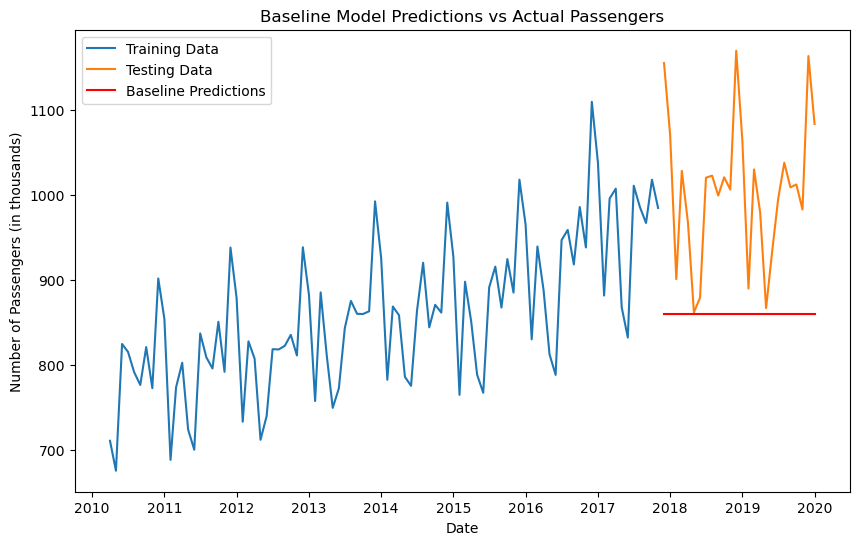

Mean Number of Passengers: 859443.4891304348


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = "ACSA_passenger_data.csv"
df = pd.read_csv(file_path)

# Data Preprocessing
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values(by='Date')
df['Passengers'] = pd.to_numeric(df['Passengers'], errors='coerce')

# Split the data into training and testing sets
train_data = df[df['Date'] < "2017-12-01"]
test_data = df[(df['Date'] >= "2017-12-01") & (df['Date'] <= "2020-01-01")]

# Compute the Baseline Prediction
mean_passengers = train_data['Passengers'].mean()

# Evaluate the Model
test_data = test_data.copy()  # Create a copy to avoid the SettingWithCopyWarning
train_data = train_data.copy()
test_data['Baseline_Prediction'] = mean_passengers
mae_baseline = np.mean(np.abs(test_data['Passengers'] - test_data['Baseline_Prediction']))

# Convert passengers to thousands for better visualization
train_data.loc[:, 'Passengers_Thousands'] = train_data['Passengers'] / 1000
test_data.loc[:, 'Passengers_Thousands'] = test_data['Passengers'] / 1000
test_data.loc[:, 'Baseline_Prediction_Thousands'] = test_data['Baseline_Prediction'] / 1000

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data['Date'], train_data['Passengers_Thousands'], label="Training Data")
plt.plot(test_data['Date'], test_data['Passengers_Thousands'], label="Testing Data")
plt.plot(test_data['Date'], test_data['Baseline_Prediction_Thousands'], label="Baseline Predictions", color="red")
plt.legend()
plt.title("Baseline Model Predictions vs Actual Passengers")
plt.xlabel("Date")
plt.ylabel("Number of Passengers (in thousands)")
plt.show()

# Display results
print(f"Mean Number of Passengers: {mean_passengers}")

#### Continuing the question:
- <b> b) any more advanced model. </b>

I used the Polynomial Regression Model using sine and cosine transformations for my advanced model.

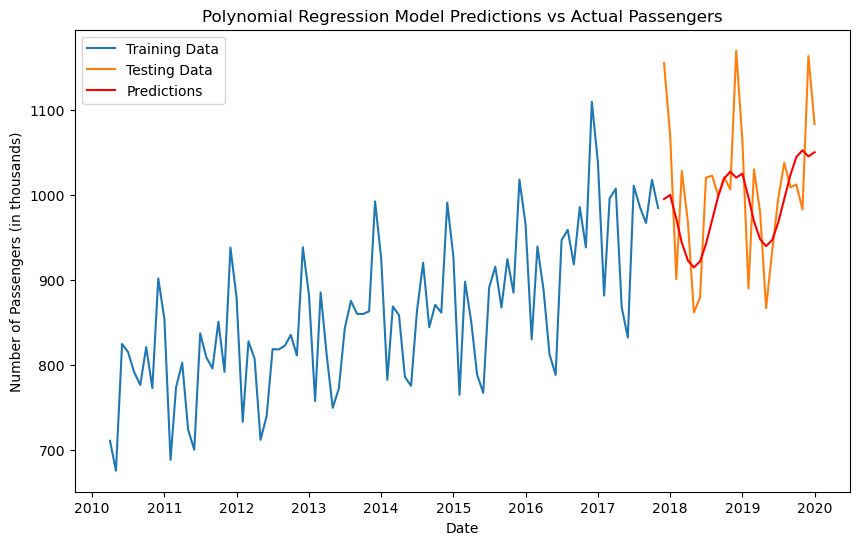

         Date  Actual_Passengers  Predicted_Passengers
0  2017-12-01            1155024                995144
1  2018-01-01            1070091                999941
2  2018-02-01             900941                971895
3  2018-03-01            1028221                943618
4  2018-04-01             967348                922688
5  2018-05-01             861814                914711
6  2018-06-01             879044                921826
7  2018-07-01            1020250                942127
8  2018-08-01            1022623                970173
9  2018-09-01             999223                998450
10 2018-10-01            1020706               1019381
11 2018-11-01            1006321               1027357
12 2018-12-01            1169540               1020242
13 2019-01-01            1064106               1025039
14 2019-02-01             889859                996993
15 2019-03-01            1029984                968716
16 2019-04-01             979241                947785
17 2019-05

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Load the data
file_path = "ACSA_passenger_data.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Ensure data is sorted by date
df = df.sort_index()

# Feature engineering to capture seasonality
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Split the data into training and testing sets
train_data = df[df.index < "2017-12-01"].copy()
test_data = df[(df.index >= "2017-12-01") & (df.index <= "2020-01-01")].copy()

# Prepare the training and testing data
X_train = train_data[['Year', 'Month_Sin', 'Month_Cos']]
y_train = train_data["Passengers"]

X_test = test_data[['Year', 'Month_Sin', 'Month_Cos']]
y_test = test_data["Passengers"]

# Apply Polynomial Features
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the Polynomial Regression Model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make Predictions
predictions = model.predict(X_test_poly)

# Evaluate the Model
mae_poly = mean_absolute_error(y_test, predictions)

# Convert passengers to thousands for better visualization
train_data['Passengers_Thousands'] = train_data['Passengers'] / 1000
test_data['Passengers_Thousands'] = test_data['Passengers'] / 1000
predictions_thousands = predictions / 1000

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Passengers_Thousands'], label="Training Data")
plt.plot(test_data.index, test_data['Passengers_Thousands'], label="Testing Data")
plt.plot(test_data.index, predictions_thousands, label="Predictions", color="red")
plt.legend()
plt.title("Polynomial Regression Model Predictions vs Actual Passengers")
plt.xlabel("Date")
plt.ylabel("Number of Passengers (in thousands)")
plt.show()

# Display the predictions and actual values
results = pd.DataFrame({
    "Actual_Passengers": y_test,
    "Predicted_Passengers": predictions
}).reset_index()
results['Predicted_Passengers'] = results['Predicted_Passengers'].round().astype(int)
print(results.head(20))

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import cross_val_score

# Load and preprocess the data
file_path = "ACSA_passenger_data.csv"
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
df = df.sort_index()
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Split the data into training and testing sets
train_data = df[df.index < "2017-12-01"]
test_data = df[(df.index >= "2017-12-01") & (df.index <= "2020-01-01")].copy()

# Baseline prediction
mean_passengers = train_data['Passengers'].mean()
test_data['Baseline_Prediction'] = mean_passengers

# Prepare the training and testing data
X_train = train_data[['Year', 'Month_Sin', 'Month_Cos']]
y_train = train_data["Passengers"]
X_test = test_data[['Year', 'Month_Sin', 'Month_Cos']]
y_test = test_data["Passengers"]

# Polynomial Regression Model
poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model = LinearRegression()
model.fit(X_train_poly, y_train)
y_pred_poly = model.predict(X_test_poly)

# Evaluation Metrics
def print_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    mbd = np.mean(y_pred - y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"{model_name} Mean Absolute Error (MAE): {mae}")
    print(f"{model_name} Root Mean Squared Error (RMSE): {rmse}")
    print(f"{model_name} R-squared (R2): {r2}")
    print(f"{model_name} Mean Squared Error (MSE): {mse}")
    print(f"{model_name} Median Absolute Error (MedAE): {medae}")
    print(f"{model_name} Mean Bias Deviation (MBD): {mbd}")
    print(f"{model_name} Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print()

# Print metrics for Baseline and Polynomial Regression models
print_metrics(y_test, test_data['Baseline_Prediction'], "Baseline Model")
print_metrics(y_test, y_pred_poly, "Polynomial Regression Model")

Baseline Model Mean Absolute Error (MAE): 146287.43394648828
Baseline Model Root Mean Squared Error (RMSE): 168162.5970494375
Baseline Model R-squared (R2): -3.111079450073616
Baseline Model Mean Squared Error (MSE): 28278659046.41148
Baseline Model Median Absolute Error (MedAE): 151093.0108695652
Baseline Model Mean Bias Deviation (MBD): -146287.43394648828
Baseline Model Mean Absolute Percentage Error (MAPE): 13.96%

Polynomial Regression Model Mean Absolute Error (MAE): 57378.60302947519
Polynomial Regression Model Root Mean Squared Error (RMSE): 70118.57829049136
Polynomial Regression Model R-squared (R2): 0.2852350266837116
Polynomial Regression Model Mean Squared Error (MSE): 4916615021.479767
Polynomial Regression Model Median Absolute Error (MedAE): 48555.24106169492
Polynomial Regression Model Mean Bias Deviation (MBD): -19143.600494087317
Polynomial Regression Model Mean Absolute Percentage Error (MAPE): 5.63%



#### Looking at the results it clearly indicates that the Polynomial Regression model outperforms the Baseline model across all evaluated metrics, this superiority is particularly evident in the following key areas:

* **Mean Absolute Error (MAE):**

  * **Baseline Model:** 146287.43  
  * **Polynomial Regression Model:** 57378.60  
  The MAE for the Polynomial Regression model is significantly lower than that of the Baseline model, indicating that the average magnitude of the errors in predictions is much smaller for the Polynomial Regression model. This suggests more accurate and consistent predictions.

* **Root Mean Squared Error (RMSE):**

  * **Baseline Model:** 168162.60  
  * **Polynomial Regression Model:** 70118.58  
  The RMSE, which penalizes larger errors more heavily, is much lower for the Polynomial Regression model. This indicates that the Polynomial Regression model makes fewer large errors compared to the Baseline model, resulting in more reliable predictions.

* **R-squared (R2):**

  * **Baseline Model:** -3.11  
  * **Polynomial Regression Model:** 0.29  
  The negative R-squared value for the Baseline model indicates that it performs worse than simply predicting the mean of the observed values. This happens because the model's residual sum of squares (the differences between observed and predicted values) is greater than the total sum of squares (the differences between observed values and their mean). In contrast, the positive R-squared value for the Polynomial Regression model indicates that it captures underlying patterns and trends, allowing it to explain 29% of the variance in the data. This demonstrates the Polynomial Regression model's ability to provide predictions that are closer to the actual observed values.

* **Mean Squared Error (MSE):**

  * **Baseline Model:** 28278659046.41  
  * **Polynomial Regression Model:** 4916615021.48  
  The MSE for the Polynomial Regression model is significantly lower, indicating better overall accuracy. The MSE metric, which also penalizes larger errors more heavily, shows that the Polynomial Regression model's predictions are closer to the actual values on average.

* **Median Absolute Error (MedAE):**

  * **Baseline Model:** 151093.01  
  * **Polynomial Regression Model:** 48555.24  
  The MedAE for the Polynomial Regression model is much lower, suggesting that for half of the predictions, the errors are less than approximately 48555.24. This indicates more consistent predictions from the Polynomial Regression model compared to the Baseline model.

* **Mean Bias Deviation (MBD):**

  * **Baseline Model:** -146287.43  
  * **Polynomial Regression Model:** -19143.60  
  The MBD for the Polynomial Regression model is closer to zero, indicating less systematic bias in its predictions. This suggests that the Polynomial Regression model does not consistently overestimate or underestimate the number of passengers, leading to more balanced predictions.

* **Mean Absolute Percentage Error (MAPE):**

  * **Baseline Model:** 13.96%  
  * **Polynomial Regression Model:** 5.63%  
  The MAPE for the Polynomial Regression model is much lower, indicating better relative accuracy. The lower MAPE shows that the average percentage error of the predictions relative to the actual values is smaller for the Polynomial Regression model, making it more reliable for forecasting purposes.


### Conclusion

The analysis shows that the Polynomial Regression model is much better than the Baseline model in all the metrics. It gives more accurate predictions with much lower errors, including Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Squared Error (MSE), Median Absolute Error (MedAE), Mean Bias Deviation (MBD), and Mean Absolute Percentage Error (MAPE). This model's strength lies in its ability to identify and capture patterns and trends in the data, shown by its positive R-squared (R2) value, meaning it explains a significant portion of the variations in passenger numbers. In contrast, the Baseline model performs poorly, with higher errors and a negative R-squared value, indicating it is less accurate than simply predicting the average number of passengers.

The results clearly indicate that the Polynomial Regression model not only provides more accurate and consistent predictions but also handles the variance in the data more effectively. This makes it a far superior choice for forecasting passenger numbers compared to the simplistic Baseline model.